In [1]:
import re
import time

import ee
import geemap
import geopandas as gpd
from google.cloud import storage

import sys
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath(".."))  # Add the parent directory to Python path

In [2]:
BUCKET_NAME = "ciut-tablero"
GOOGLE_CLOUD_PROJECT = "ee-ciut"

In [3]:
ee.Authenticate()

ee.Initialize(project=GOOGLE_CLOUD_PROJECT)

In [4]:
target_partidos = ["La Plata", "Berisso", "Ensenada"]
gaul_l2 = ee.FeatureCollection("projects/sat-io/open-datasets/FAO/GAUL/GAUL_2024_L2")

municipalities = (
    gaul_l2.filter(ee.Filter.eq("gaul0_name", "Argentina"))
    .filter(ee.Filter.eq("gaul1_name", "Buenos Aires"))
    .filter(ee.Filter.inList("gaul2_name", target_partidos))
)

basins_gdf = gpd.read_file(
    "/home/nissim/Documents/dev/ciut-tablero/data/dipsoh_cuencas.geojson"
)
basins_ee = geemap.geopandas_to_ee(basins_gdf)
intersecting_basins = basins_ee.filterBounds(municipalities.geometry())
aoi = intersecting_basins.geometry()

In [5]:
aoi_gdf = geemap.ee_to_gdf(intersecting_basins)

In [6]:
pop_2020 = (
    ee.ImageCollection("WorldPop/GP/100m/pop")
    .filter(ee.Filter.eq("system:index", "ARG_2020"))
    .first()
    .clip(aoi)
)

pop_2010 = (
    ee.ImageCollection("WorldPop/GP/100m/pop")
    .filter(ee.Filter.eq("system:index", "ARG_2010"))
    .first()
    .clip(aoi)
)

In [7]:
hrsl = (
    ee.ImageCollection("projects/sat-io/open-datasets/hrsl/hrslpop").median().clip(aoi)
)

In [10]:
# census_2010_gdf = gpd.read_file(
#     "/home/nissim/Documents/fulbright/Conicet digital 11336_149711/RADIOS_2010_V2025-1/Radios 2010 v2025-1.shp"
# )
# census_2010_gdf.to_parquet(
#     "/home/nissim/Documents/fulbright/Conicet digital 11336_149711/RADIOS_2010_V2025-1/Radios 2010 v2025-1.parquet"
# )

In [7]:
census_2010_gdf = gpd.read_parquet(
    "/home/nissim/Documents/fulbright/Conicet digital 11336_149711/RADIOS_2010_V2025-1/Radios 2010 v2025-1.parquet"
)

In [8]:
# First ensure they're in the same projection
if census_2010_gdf.crs != aoi_gdf.crs:
    aoi_gdf = aoi_gdf.to_crs(census_2010_gdf.crs)

# Perform the spatial clip
clipped_census = gpd.clip(census_2010_gdf, aoi_gdf)
# First do the type conversions on the GeoDataFrame
clipped_census = clipped_census[["COD_2010", "B_POB_TOT", "geometry"]]
clipped_census["COD_2010"] = clipped_census["COD_2010"].astype(str)
clipped_census["B_POB_TOT"] = clipped_census["B_POB_TOT"].astype(int)

# Then convert to Earth Engine
census_2010_ee = geemap.geopandas_to_ee(clipped_census)

In [9]:
ghsl = ee.Image("JRC/GHSL/P2023A/GHS_POP/2010").clip(aoi)

ghsl = ghsl.updateMask(ghsl.gt(0))

In [ ]:
# Create map and center on AOI
Map = geemap.Map(basemap="CartoDB.Positron")
Map.centerObject(aoi, 8)

Map.addLayer(
    pop_2010,
    {
        "bands": ["population"],
        "min": 0.0,
        "max": 50.0,
        "palette": ["24126c", "1fff4f", "d4ff50"],
    },
    "WorldPop Population (2010, 100m)",
    shown=False,  # Start with layer off
)

Map.addLayer(
    hrsl,
    {
        "min": 0.0,
        "max": 500.0,
        "palette": ["24126c", "1fff4f", "d4ff50"],
    },
    "HRSL (2016, 30m)",
    shown=False,  # Start with layer off
)

Map.addLayer(
    ghsl,
    {
        "min": 0.0,
        "max": 100.0,
        "palette": [
            "000004",
            "320A5A",
            "781B6C",
            "BB3654",
            "EC6824",
            "FBB41A",
            "FCFFA4",
        ],
    },
    "GHSL (2010, 100m)",
    shown=False,  # Start with layer off
)

vis_params = {
    "color": "000000",  # Black border
    "colorOpacity": 1,
    "width": 1,  # Thinner border for census tracts
    "lineType": "solid",
    "fillColorOpacity": 0.8,  # Slightly more opaque for better visibility
}

# Using a population-appropriate color palette (from low to high population)
palette = [
    "#f7fbff",
    "#deebf7",
    "#c6dbef",
    "#9ecae1",
    "#6baed6",
    "#4292c6",
    "#2171b5",
    "#08519c",
    "#08306b",
]

Map.add_styled_vector(
    census_2010_ee,
    column="B_POB_TOT",
    palette=palette,
    layer_name="Censo 2010",
    **vis_params,
)

Map

Map(center=[-35.23620217745599, -57.97610800815036], controls=(WidgetControl(options=['position', 'transparent…

In [17]:
out_census_stats = "census_stats.csv"
geemap.zonal_stats(
    pop_2010, census_2010_ee, out_census_stats, stat_type="SUM", scale=100
)

out_hrsl_stats = "hrsl_stats.csv"
geemap.zonal_stats(hrsl, census_2010_ee, out_hrsl_stats, stat_type="SUM", scale=30)

out_ghsl_stats = "ghsl_stats.csv"
geemap.zonal_stats(ghsl, census_2010_ee, out_ghsl_stats, stat_type="SUM", scale=100)

Computing statistics ...
Generating URL ...
Please wait ...
Data downloaded to /home/nissim/Documents/dev/ciut-tablero/notebooks/census_stats.csv


In [14]:
out_ghsl_stats = "ghsl_stats.geojson"
geemap.zonal_stats(ghsl, census_2010_ee, out_ghsl_stats, stat_type="SUM", scale=100)

Computing statistics ...
Generating URL ...
Please wait ...
Data downloaded to /home/nissim/Documents/dev/ciut-tablero/notebooks/ghsl_stats.geojson


In [12]:
out_ghsl_stats = "ghsl_stats.geojson"
ghsl_2010_spatial = gpd.read_file(out_ghsl_stats)

In [13]:
# Replace zeros with NaN in census data
ghsl_2010_spatial["B_POB_TOT"] = ghsl_2010_spatial["B_POB_TOT"].replace(0, np.nan)
ghsl_2010_spatial["pct_error"] = (
    (ghsl_2010_spatial["sum"] - ghsl_2010_spatial["B_POB_TOT"])
    / ghsl_2010_spatial["B_POB_TOT"]
    * 100
)

In [27]:
from pyproj import Geod

# Create a Geod object for area calculations
geod = Geod(ellps='WGS84')

# Calculate area in square meters
ghsl_2010_spatial['area'] = ghsl_2010_spatial['geometry'].apply(
    lambda geom: abs(geod.geometry_area_perimeter(geom)[0])
)

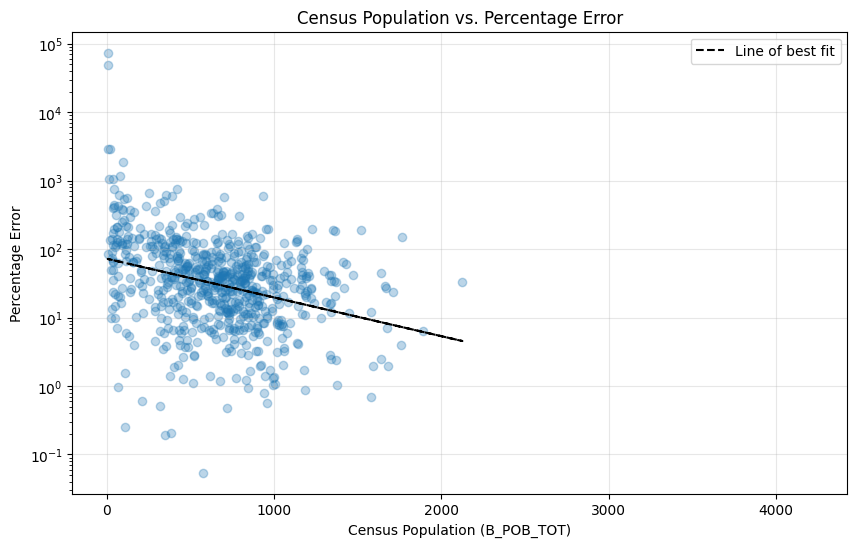

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Initialize the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the scatter points
ax.scatter(ghsl_2010_spatial["B_POB_TOT"], ghsl_2010_spatial["pct_error"], alpha=0.3)

# Calculate and plot line of best fit in log space
mask = (
    ~np.isnan(ghsl_2010_spatial["B_POB_TOT"])
    & ~np.isnan(ghsl_2010_spatial["pct_error"])
    & (ghsl_2010_spatial["pct_error"] > 0)
)  # Only positive values for log
x = ghsl_2010_spatial["B_POB_TOT"][mask]
y = ghsl_2010_spatial["pct_error"][mask]
z = np.polyfit(x, np.log10(y), 1)
p = np.poly1d(z)
ax.plot(x, 10 ** p(x), "k--", label="Line of best fit")

# Set the y-axis to log scale
ax.set_yscale("log")

# Set labels and title
ax.set_xlabel("Census Population (B_POB_TOT)")
ax.set_ylabel("Percentage Error")
ax.set_title("Census Population vs. Percentage Error")
ax.grid(True, alpha=0.3)
ax.legend()

# Display the plot
plt.show()

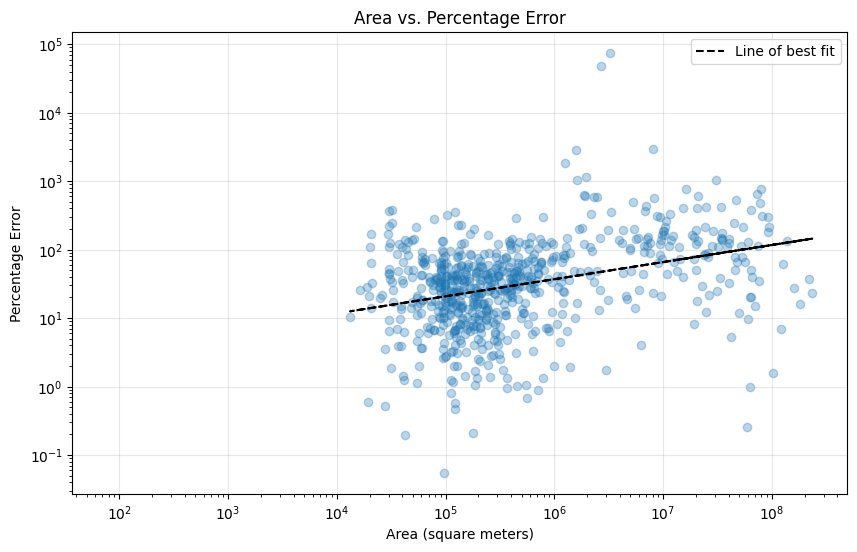

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Initialize the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the scatter points
ax.scatter(ghsl_2010_spatial["area"], ghsl_2010_spatial["pct_error"], alpha=0.3)

# Calculate and plot line of best fit in log space
mask = (
    ~np.isnan(ghsl_2010_spatial["area"])
    & ~np.isnan(ghsl_2010_spatial["pct_error"])
    & (ghsl_2010_spatial["pct_error"] > 0)
)  # Only positive values for log
x = np.log10(ghsl_2010_spatial["area"][mask])
y = np.log10(ghsl_2010_spatial["pct_error"][mask])
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
ax.plot(10**x, 10 ** p(x), "k--", label="Line of best fit")

# Set both axes to log scale
ax.set_xscale("log")
ax.set_yscale("log")

# Set labels and title
ax.set_xlabel("Area (square meters)")
ax.set_ylabel("Percentage Error")
ax.set_title("Area vs. Percentage Error")
ax.grid(True, alpha=0.3)
ax.legend()

# Display the plot
plt.show()

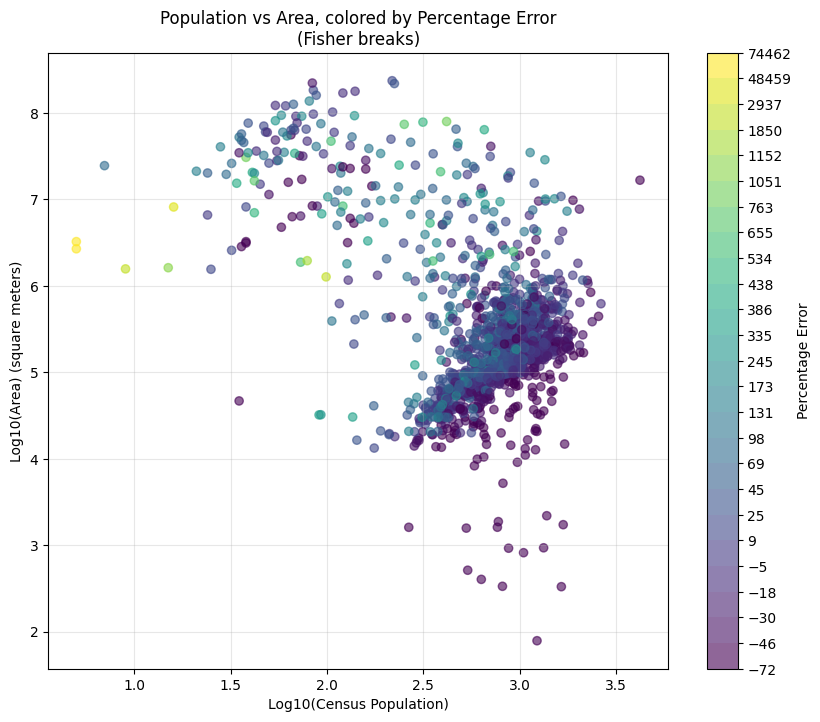

In [30]:
import matplotlib.pyplot as plt
import numpy as np
from mapclassify import NaturalBreaks
import matplotlib.colors as colors

# Initialize the figure and axis
fig, ax = plt.subplots(figsize=(10, 8))

# Remove NaN values for the classification
mask = ~np.isnan(ghsl_2010_spatial["pct_error"])
pct_error_clean = ghsl_2010_spatial["pct_error"][mask]

# Calculate Fisher breaks for pct_error
classifier = NaturalBreaks(pct_error_clean, k=25)
breaks = classifier.bins

# Create a discrete colormap
cmap = plt.cm.viridis
norm = colors.BoundaryNorm(breaks, cmap.N)

# Create the scatter plot with color based on pct_error using Fisher breaks
scatter = ax.scatter(
    np.log10(ghsl_2010_spatial["B_POB_TOT"]),
    np.log10(ghsl_2010_spatial["area"]),
    c=ghsl_2010_spatial["pct_error"],
    cmap=cmap,
    norm=norm,
    alpha=0.6,
)

# Add colorbar with break points
cbar = plt.colorbar(scatter)
cbar.set_label("Percentage Error")
cbar.set_ticks(breaks)

# Set labels and title
ax.set_xlabel("Log10(Census Population)")
ax.set_ylabel("Log10(Area) (square meters)")
ax.set_title("Population vs Area, colored by Percentage Error\n(Fisher breaks)")

# Add grid
ax.grid(True, alpha=0.3)

# Display the plot
plt.show()

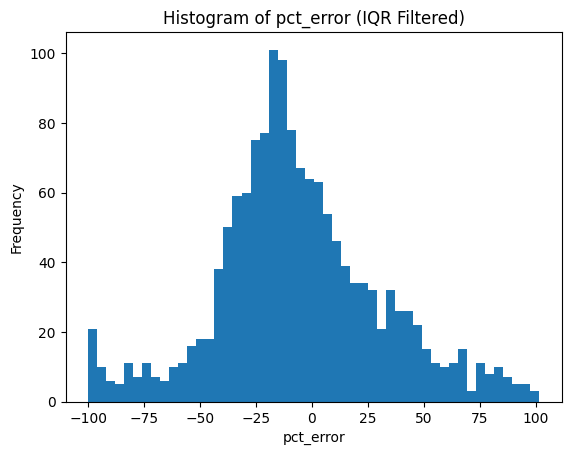

In [35]:
import numpy as np
import matplotlib.pyplot as plt

Q1 = ghsl_2010_spatial["pct_error"].quantile(0.25)
Q3 = ghsl_2010_spatial["pct_error"].quantile(0.75)
IQR = Q3 - Q1

# Define bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter data within bounds
filtered_errors = ghsl_2010_spatial["pct_error"][
    (ghsl_2010_spatial["pct_error"] >= lower_bound)
    & (ghsl_2010_spatial["pct_error"] <= upper_bound)
]

# Plot the histogram
plt.hist(filtered_errors, bins=50)
plt.title("Histogram of pct_error (IQR Filtered)")
plt.xlabel("pct_error")
plt.ylabel("Frequency")
plt.show()


/home/nissim/Documents/dev/ciut-tablero/.venv/lib/python3.12/site-packages/geopandas/plotting.py:752: UserWarning: Numba not installed. Using slow pure python version.
  binning = mapclassify.classify(


<Axes: >

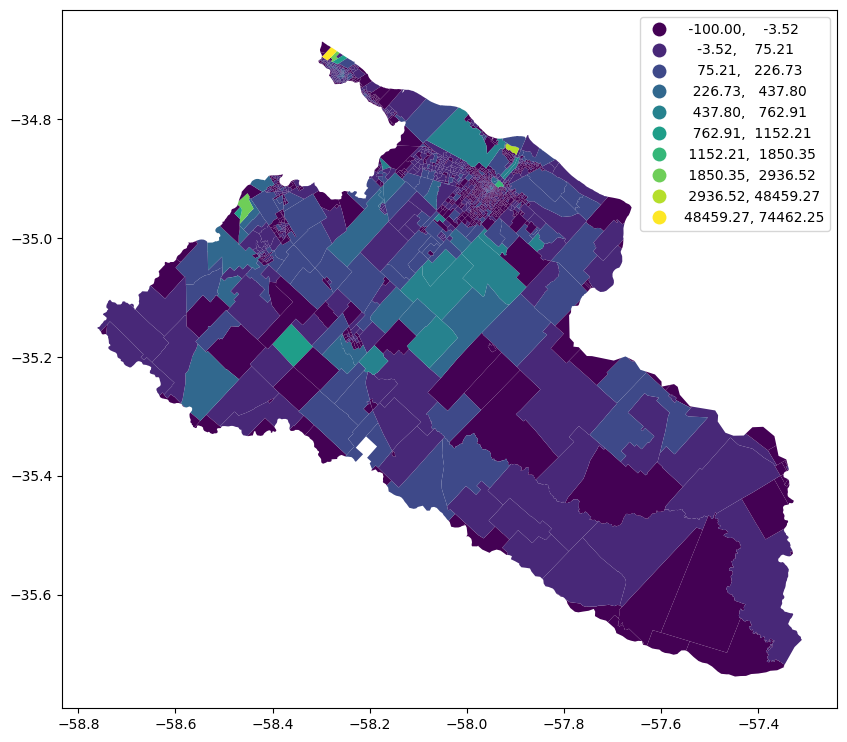

In [31]:
ghsl_2010_spatial.plot(
    column="pct_error",
    cmap="viridis",
    scheme="FisherJenks",
    k=10,
    legend=True,
    figsize=(10, 10),
)

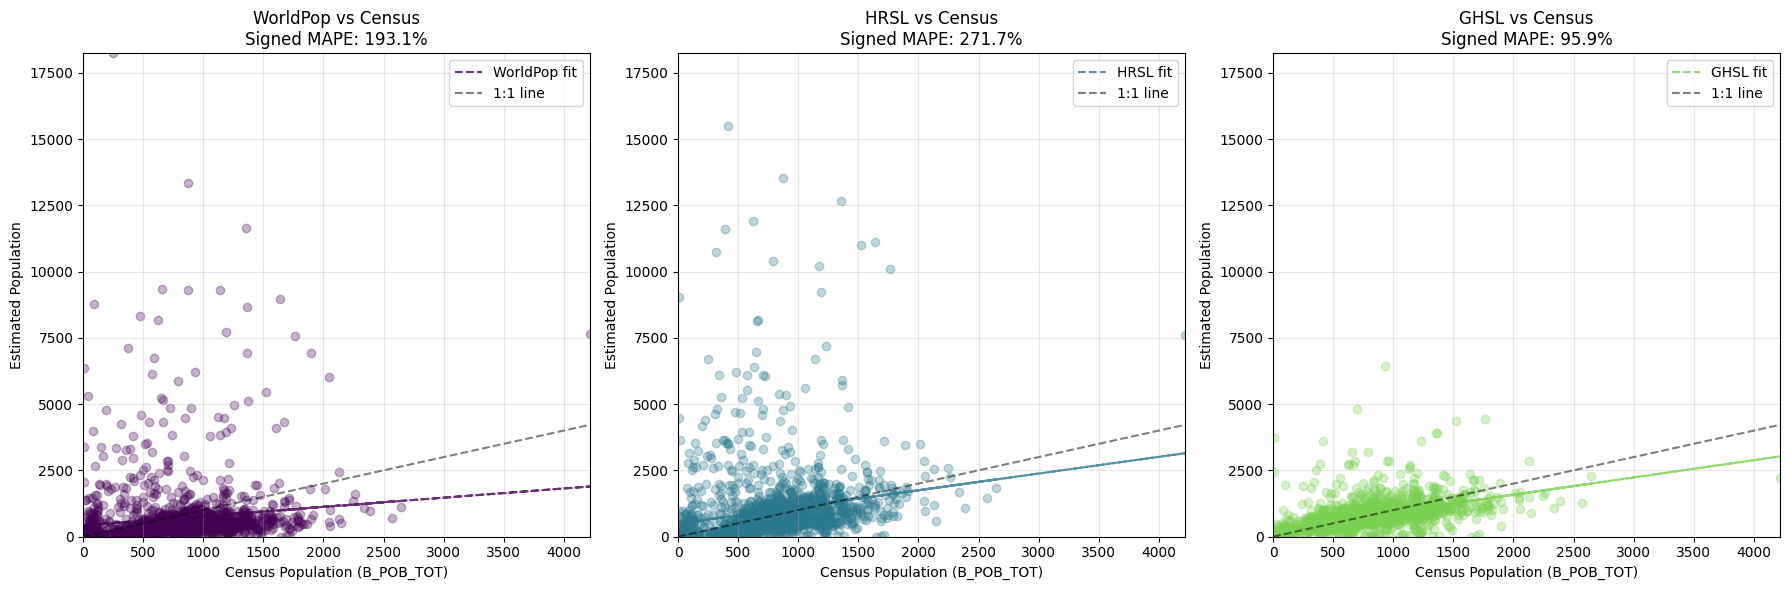

In [36]:
# Read the CSV files
census_df = pd.read_csv("census_stats.csv")
hrsl_df = pd.read_csv("hrsl_stats.csv")
ghsl_df = pd.read_csv("ghsl_stats.csv")

# Replace zeros with NaN in census data
census_pop = census_df["B_POB_TOT"].replace(0, np.nan)


# Calculate signed MAPE for each dataset
def calculate_signed_mape(actual, predicted):
    # Filter out NaN values
    mask = ~np.isnan(actual)
    return np.mean((predicted[mask] - actual[mask]) / actual[mask]) * 100


worldpop_mape = calculate_signed_mape(census_pop, census_df["sum"])
hrsl_mape = calculate_signed_mape(census_pop, hrsl_df["sum"])
ghsl_mape = calculate_signed_mape(census_pop, ghsl_df["sum"])

# Create figure with subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
axes = [ax1, ax2, ax3]

# Use viridis colormap for colorblind-friendly colors
colors = plt.cm.viridis(np.linspace(0, 0.8, 3))

# Calculate max values separately for x and y axes
max_x = census_pop.max()
max_y = max(census_df["sum"].max(), hrsl_df["sum"].max(), ghsl_df["sum"].max())

# Plot each dataset in its own subplot
datasets = [
    (census_df["sum"], "WorldPop", worldpop_mape, colors[0]),
    (hrsl_df["sum"], "HRSL", hrsl_mape, colors[1]),
    (ghsl_df["sum"], "GHSL", ghsl_mape, colors[2]),
]

for ax, (data, label, mape, color) in zip(axes, datasets):
    # Plot scatter points
    ax.scatter(census_pop, data, alpha=0.3, color=color)

    # Calculate and plot line of best fit
    mask = ~np.isnan(census_pop)
    z = np.polyfit(census_pop[mask], data[mask], 1)
    p = np.poly1d(z)
    ax.plot(
        census_pop, p(census_pop), "--", color=color, alpha=0.8, label=f"{label} fit"
    )

    # Add 1:1 line
    ax.plot([0, max_x], [0, max_x], "k--", alpha=0.5, label="1:1 line")

    # Customize subplot
    ax.set_xlabel("Census Population (B_POB_TOT)")
    ax.set_ylabel("Estimated Population")
    ax.set_title(f"{label} vs Census\nSigned MAPE: {mape:.1f}%")
    ax.grid(True, alpha=0.3)

    # Set consistent axes limits
    ax.set_xlim(0, max_x)
    ax.set_ylim(0, max_y)

    # Add legend
    ax.legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [6]:
# Define years to process
years = [2000, 2005, 2010, 2015, 2020, 2025, 2030]

# Create a list to hold all images with year as property
ghsl_images = []

# Create images with year property already set
for year in years:
    image_path = f"JRC/GHSL/P2023A/GHS_POP/{year}"
    img = ee.Image(image_path).clip(aoi)

    # First identify the band name by printing the first image
    if year == 2000:
        print(f"Available bands: {img.bandNames().getInfo()}")

    img = img.updateMask(img.gt(0))
    # Set year as a property directly
    img = img.set("year", ee.Number(year))
    ghsl_images.append(img)

# Create an ImageCollection from the list of images
ghsl_collection = ee.ImageCollection(ghsl_images)

# Calculate zonal statistics for all years at once
features = intersecting_basins.toList(intersecting_basins.size())


# This creates a FeatureCollection with all statistics
def calculate_stats(feature):
    feature = ee.Feature(feature)

    # Process each year
    for year in years:
        # Filter collection to get image for this year
        img = ghsl_collection.filter(ee.Filter.eq("year", year)).first()

        # Get the correct band name - will be first band in the image
        band_name = ee.Image(img).bandNames().get(0)

        # Calculate sum for this feature/basin
        stats = img.reduceRegion(
            reducer=ee.Reducer.sum(),
            geometry=feature.geometry(),
            scale=100,
            maxPixels=1e13,  # Increase for large areas
        )

        # Get the population value using the dynamic band name
        pop_value = ee.Number(stats.get(band_name)).round()

        # Set as property with year in the name
        feature = feature.set(f"pop_{year}", pop_value)

    return feature


# Server-side mapping function to process all features
result_fc = ee.FeatureCollection(features.map(lambda f: calculate_stats(ee.Feature(f))))


# Convert directly to GeoDataFrame for inspection
def inspect_result():
    """Convert FeatureCollection to GeoDataFrame and inspect"""
    try:
        # Directly convert to GeoDataFrame
        result_gdf = geemap.ee_to_gdf(result_fc)

        return result_gdf
    except Exception as e:
        print(f"Error converting to GeoDataFrame: {e}")

        # Fallback: Try to get at least one feature to understand the structure
        try:
            first_feature = result_fc.first().getInfo()
            print("\nFirst feature properties:")
            print(first_feature["properties"])

            # Check if we got band name wrong
            band_names = ghsl_collection.first().bandNames().getInfo()
            print(f"\nActual band names: {band_names}")
        except Exception as e2:
            print(f"Further inspection failed: {e2}")

        return None


# Inspect the result
result_gdf = inspect_result()

Available bands: ['population_count']


In [7]:
def create_tidy_geodataframe(result_gdf):
    """
    Convert the wide-format GeoDataFrame to a tidy (long) format with:
    - nombre: Combined name from nombre and sucuenca_n columns
    - year: Year of population estimate
    - pob: Population value
    """
    # First, create a clean nombre column that combines nombre and sucuenca_n
    result_gdf["nombre_clean"] = result_gdf.apply(
        lambda row: (
            f"{row['nombre']}, {row['sucuenca_n']}"
            if pd.notna(row["sucuenca_n"])
            else row["nombre"]
        ),
        axis=1,
    )

    # Identify population columns by prefix
    pop_columns = [col for col in result_gdf.columns if col.startswith("pop_")]

    # List of columns to keep (non-population columns)
    keep_columns = ["geometry", "nombre_clean"]

    # Create an empty list to store dataframes for each year
    dfs = []

    # Process each year's population column
    for pop_col in pop_columns:
        # Extract year from column name
        year = int(pop_col.split("_")[1])

        # Create a copy of the DF with only required columns
        year_df = result_gdf[keep_columns + [pop_col]].copy()

        # Rename population column to 'pob'
        year_df = year_df.rename(columns={pop_col: "pob"})

        # Add year column
        year_df["year"] = year

        # Append to list of dataframes
        dfs.append(year_df)

    # Concatenate all dataframes
    tidy_gdf = pd.concat(dfs, ignore_index=True)

    # Reorder columns for clarity
    tidy_gdf = tidy_gdf[["geometry", "nombre_clean", "year", "pob"]]

    # Rename nombre_clean to nombre
    tidy_gdf = tidy_gdf.rename(columns={"nombre_clean": "nombre"})

    return tidy_gdf


# Apply the function to convert to tidy format
tidy_gdf = create_tidy_geodataframe(result_gdf)

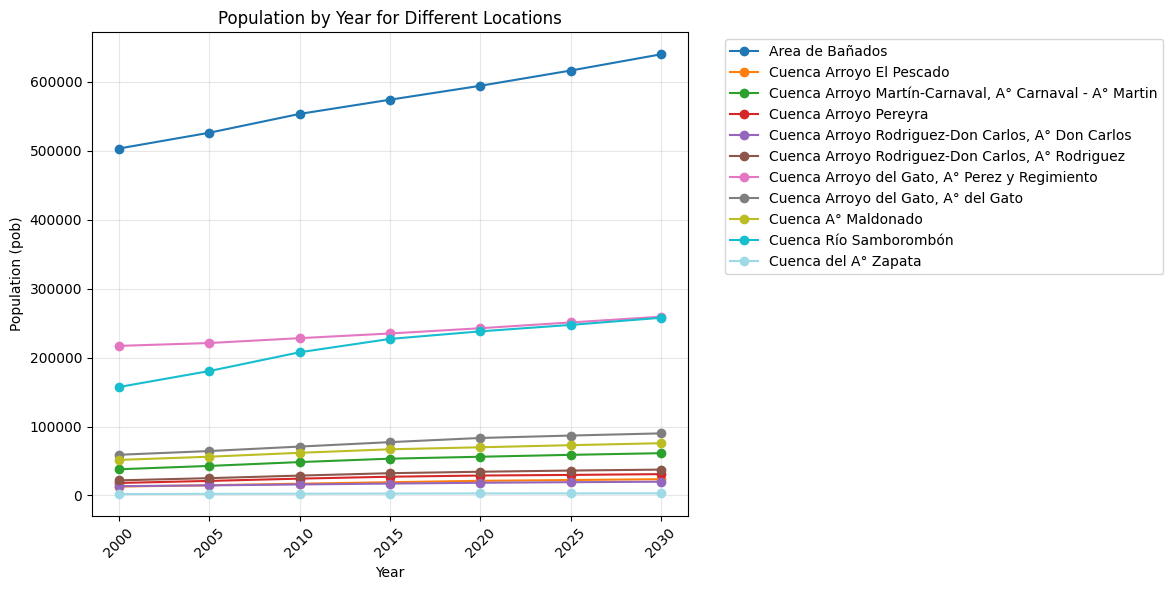

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming tidy_gdf is already loaded

# Group by nombre and year, and calculate the sum of pob for each group
grouped = tidy_gdf.groupby(["nombre", "year"])["pob"].sum().reset_index()

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Get unique nombres for colors
nombres = grouped["nombre"].unique()
colors = plt.cm.tab20(np.linspace(0, 1, len(nombres)))

# Plot each nombre as a separate line
for i, nombre in enumerate(nombres):
    data = grouped[grouped["nombre"] == nombre]
    ax.plot(
        data["year"],
        data["pob"],
        marker="o",
        linestyle="-",
        label=nombre,
        color=colors[i],
    )

# Add labels and title
ax.set_xlabel("Year")
ax.set_ylabel("Population (pob)")
ax.set_title("Population by Year for Different Locations")

# Add legend (if there are many locations, you may want to adjust the placement)
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

# Add grid for better readability
ax.grid(True, alpha=0.3)

# Rotate x-axis labels if needed
plt.xticks(rotation=45)

# Adjust layout to make room for the legend
plt.tight_layout()

# Show the plot
plt.show()